# Running the snmachine pipeline on PLAsTiCC simulated data

This notebook illustrates the use of the `snmachine` supernova classification package by classifying a subset simulated data from the photometric light curve astronomical time-series classification challenge (PLAsTiCC). 

See Lochner et al. (2016): http://arxiv.org/abs/1603.00882 and Alves et al. (2021): https://arxiv.org/abs/2107.07531

**NOTE:** The results here differ from the paper because we're using a much smaller dataset (in the interest of disk space and speed).

<img src="snmachine-plasticc.png" width=250>

This image illustrates the pipeline we use for this work. However, all the steps are modular and can be replaced. It is easy to write your own algorithm into the pipeline and change any of the stpes.

## Setup

### Imports

In [1]:
import collections
import os
import pickle

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
from snmachine import example_data, sndata, gps, snaugment, snfeatures, snclassifier, analysis, tsne_plot
from snmachine.utils.plasticc_pipeline import create_folder_structure, get_directories, load_dataset

In [4]:
%config Completer.use_jedi = False  # enable autocomplete

### Aesthetic settings

In [5]:
%matplotlib widget

sns.set(font_scale=1.3, style="ticks")

### Read from pickle or rerun
Because some calculations take incredibly long to run on a single core (mostly the Gaussian process augmentation), we recommend saving these objects as pickles and read from file after running once. This behaviour can be turned off with this flag.

In [6]:
read_from_pickle = True

## Set up output structure

We make lots of output files so it makes sense to put them in one place. This is the recommended output file structure.

We start by **naming** our analysis.

In [7]:
dataset_name = 'plasticc'
analysis_name = os.path.join(f'output_{dataset_name}', )

Then, we **write** in `folder_path` the path where to save the folder.

In [8]:
folder_path = '../snmachine/example_data/'

Create the folder structure.

In [9]:
create_folder_structure(folder_path, analysis_name)

See the folder structure. We save:
* the extracted features in `directories['features_directory']`
* the classification probabilities and ROC curves in `directories['classifications_directory']`
* the any intermediate files (such as multinest chains or GP fits) in `directories['intermediate_files_directory']`

In [10]:
directories = get_directories(folder_path, analysis_name) 
directories

{'analysis_directory': '../snmachine/example_data/output_plasticc',
 'features_directory': '../snmachine/example_data/output_plasticc/wavelet_features',
 'classifications_directory': '../snmachine/example_data/output_plasticc/classifications',
 'intermediate_files_directory': '../snmachine/example_data/output_plasticc/intermediate_files',
 'plots_directory': '../snmachine/example_data/output_plasticc/plots'}

In [11]:
path_saved_features = directories['features_directory']
path_saved_interm = directories['intermediate_files_directory']
path_saved_classifier = directories['classifications_directory']

## Initialise dataset object

Load the PLAsTiCC training data (hosted https://doi.org/10.5281/zenodo.2539456). For that, we **write** the path where the data is, and the name of the files.

In [12]:
data_path = '../snmachine/example_data'

data_file_name = 'plasticc_train_lightcurves.csv'
metadata_file_name = 'plasticc_train_metadata.csv'

In [13]:
# This cell takes ~2min to run
dataset = sndata.PlasticcData(folder=data_path, data_file=data_file_name,
                              metadata_file=metadata_file_name)

Reading data...
10%
20%
30%
40%
50%
60%
70%
80%
90%
7848 objects read into memory.
This has taken 0 days 00:00:43

Reading metadata...
10%
20%
30%
40%
50%
60%
70%
80%
90%
Finished getting the metadata for 7848 objects.
This has taken 0 days 00:00:06



For now we restrict ourselves to three supernova types: Ia (90), II (42) and Ibc (62).

In [14]:
metadata = dataset.metadata
is_snia = metadata.target == 90  # SN Ia
is_snibc = metadata.target == 62  # SN Ibc
is_snii = metadata.target == 42  # SN II

In [15]:
objs_to_keep = metadata['object_id'][is_snia | is_snibc | is_snii]
objs_to_keep = np.array(objs_to_keep).flatten()

Update the dataset to only contain those SNe.

In [16]:
dataset.update_dataset(objs_to_keep)

Now we can plot all the data and cycle through it (left and right arrows on your keyboard).

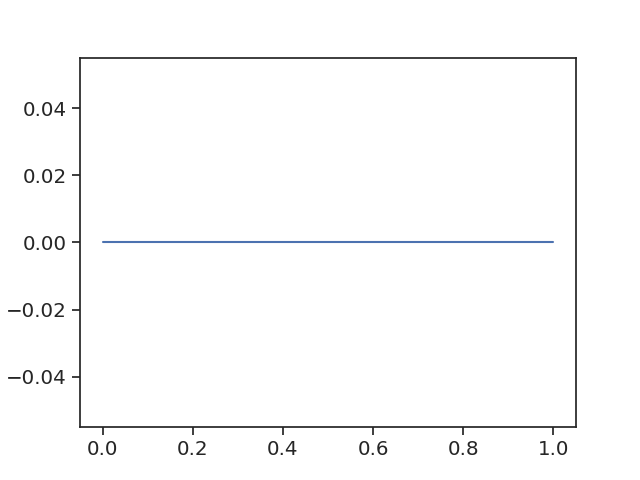

In [17]:
dataset.plot_all()

Each light curve is represented in the Dataset object as an astropy table, compatible with `sncosmo`:

In [18]:
dataset.data[dataset.object_names[0]]

object_id,mjd,filter,flux,flux_error,detected
int64,float64,str5,float64,float64,int64
730,0.0,lsstr,1.177371,1.3643,0
730,0.007599999997182749,lsstg,2.320849,1.159247,0
730,0.015200000001641456,lssti,2.939447,1.771328,0
730,0.026099999995494727,lsstz,2.128097,2.610659,0
730,0.0371000000013737,lssty,-12.809639,5.380097,0
730,3.034800000001269,lsstr,0.111235,2.460576,0
...,...,...,...,...,...
730,848.7429999999949,lsstu,-0.756102,1.985424,0
730,849.7436999999991,lsstu,1.493417,1.464573,0


## Preprocess dataset

**Write** the maximum duration of the gap to allowed in the light curves, `max_gap_length`.

In [19]:
max_gap_length = 50

To remove all the gaps longer than `max_gap_length`, the `remove_gaps` function must be called a few times; it only removes the first gap longer than `max_gap_length`.

To introduce uniformity in the dataset, the resulting light curves are translated so their first observation is at time zero.

In [20]:
dataset.remove_gaps(max_gap_length*2, verbose=True)
dataset.remove_gaps(max_gap_length*2, verbose=True)
dataset.remove_gaps(max_gap_length, verbose=True)
dataset.remove_gaps(max_gap_length, verbose=True)
dataset.remove_gaps(max_gap_length, verbose=True)

The longest event is 17723103 and its length is 1094.06 days.
The longest event is 4445796 and its length is 882.75 days.
The longest event is 46397441 and its length is 867.67 days.
The longest event is 67713721 and its length is 618.58 days.
The longest event is 115557395 and its length is 277.55 days.


Now we can see the light curves more clearly, focusing in on the season where the supernova actually occurred

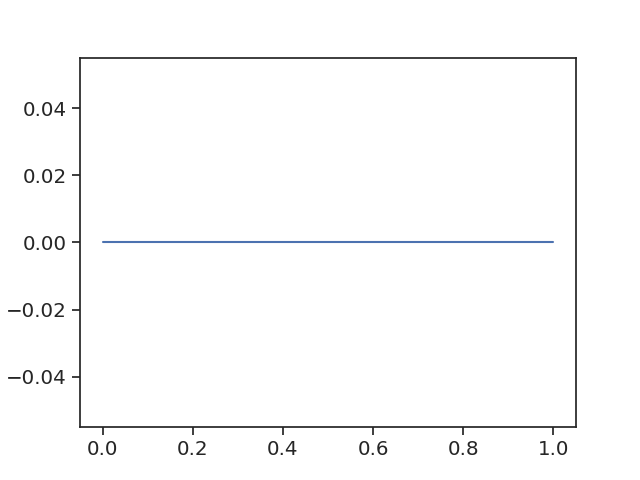

In [21]:
dataset.plot_all()

## Fit Gaussian Processes

Set the path to the folder to save the GP files.

In [22]:
path_saved_gps = directories['intermediate_files_directory']

**Choose**:
- `t_min`: minimim time to evaluate the Gaussian Process Regression at.
- `t_max`: maximum time to evaluate the Gaussian Process Regression at.
- `gp_dim`: dimension of the Gaussian Process Regression. If  `gp_dim` is 1, the filters are fitted independently. If `gp_dim` is 2, the Matern 3/2 kernel is used to fit light curves both in time and wavelength.
- `number_gp`: number of points to evaluate the Gaussian Process Regression at.
- `number_processes`: number of processors to use for parallelisation (**<font color=green>optional</font>**).

In [23]:
t_min = 0
t_max = 278

gp_dim = 2
number_gp = 276
number_processes = 1

In [25]:
dataset_pickle_name = os.path.join(folder_path, 'example_dataset.pckl')
if read_from_pickle and os.path.exists(dataset_pickle_name):
    with open(dataset_pickle_name, 'rb') as pickle_file:
        dataset = pickle.load(pickle_file)
        print('Dataset read in from', dataset_pickle_name)
else:
    # This cell can take ~4 min
    gps.compute_gps(dataset, number_gp=number_gp, t_min=t_min, t_max=t_max, 
                    gp_dim=gp_dim, output_root=path_saved_gps, 
                    number_processes=number_processes)
    
    with open(dataset_pickle_name, 'wb') as pickle_file:
        pickle.dump(dataset, pickle_file)

Performing Gaussian process regression.
Models fitted with the Gaussian Processes values.
Time taken for Gaussian process regression: 278.32s.


At the moment no other parameters are tunable for 2D Gaussian processes. For more details on this modeling of the light curves, see section _3.2. Gaussian Process Modeling of Light Curves_ of the [paper]().

Now we can see how our light curves look with GP models.

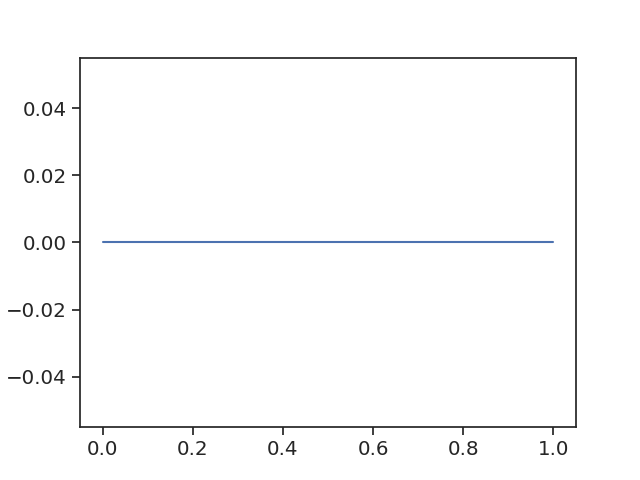

In [26]:
dataset.plot_all(plot_model=True)

## Augment Dataset

Our data augmentation requires previously fitted Gaussian Processes. So, if this was not done before, it needs to be done at this stage.

### Choose the Events to Augment<a name="chooseEvent"></a>

**Write** in `aug_obj_names` a list containing all the events to augment. Here we will try to augment them all.

In [27]:
aug_obj_names = dataset.object_names  # try to augment all events

**Create** a dictionary that associates to each event, the target number of synthetic events to create from it. Note that some augmentations will fail so this is not the final number of events. Additionally, each class has a different creation efficiency.

In [28]:
np.random.seed(42)
is_to_aug = np.in1d(dataset.object_names, aug_obj_names)

# Choose the target number of events in the augmented dataset. 
# Usually, only half of this number are accepted in the augmented dataset
target_number_aug = np.sum(is_to_aug) * 2

number_objs_per_label = collections.Counter(dataset.labels[is_to_aug])
number_aug_per_label = target_number_aug//len(number_objs_per_label.keys())
objs_number_to_aug = {}
for label in number_objs_per_label.keys():
    is_label = dataset.labels[is_to_aug] == label
    aug_is_label_obj_names = aug_obj_names[is_label]
    number_aug_per_obj = number_aug_per_label // np.sum(is_label)
    number_extra_aug_per_obj = number_aug_per_label % np.sum(is_label)
    extra_obj = np.random.choice(aug_is_label_obj_names, size=number_extra_aug_per_obj, 
                                 replace=False)
    objs_number_to_aug.update({obj: number_aug_per_obj for obj in aug_is_label_obj_names})
    objs_number_to_aug.update({obj: number_aug_per_obj+1 for obj in extra_obj})

In [29]:
print(f'We aim to create up to {sum(objs_number_to_aug.values())} events.')  # confirm how many events to create

We aim to create up to 7980 events.


### Choose the Photometric Redshift<a name="choosePhotoZ"></a>

In order to simulate realistic photometric redshifts for the synthetic events, following [Boone (2019)](https://iopscience.iop.org/article/10.3847/1538-3881/ab5182) we chose a random event from the test set events that had a spectroscopic redshift measurement, and calculated the difference between its spectroscopic and photometric redshifts. We then added this difference to the true redshift of the augmented event to generate a photometric redshift. 

**Add** such a dataset containing spectroscopic and photometric redshift, and photometric redshift error of events as `z_table`. If none is provided, a similar table is generated from the events in `dataset`.

In [30]:
# Here we use a small portion of the test data in interest of time
test_data_file_name = 'example_test_dataset.pckl'  
test_data_path = os.path.join(data_path, test_data_file_name)

test_data = load_dataset(test_data_path)
test_metadata = test_data.metadata

# Discard the events without spectroscopic redshift; 
# these are encoded with `hostgal_specz` equal to -9
z_table = test_metadata[test_metadata.hostgal_specz > -2]

Opening from binary pickle
Dataset loaded from pickle file as: <snmachine.sndata.PlasticcData object at 0x7f3f9d0135e0>


### Run Augmentation<a name="aug"></a>

We also need to choose which survey to emulate in the augmentation. At the moment `snmachine` contains the Wide-Fast-Deep (WFD) and the Deep Drilling Field (DDF) survey of the Rubin Observatory Legacy Survey of Space and Time. Use `snaugment.PlasticcWFDAugment` for the former survey and `snaugment.PlasticcDDFAugment` for the latter.
You can also implement your own augmentation using those classes as an example.

In addition to the above inputs, we **chose** the random seed (`random_seed`) used to allow reproducible results and the maximum duration of the augmented light curves (`max_duration`).

The value of `max_duration` must be higher than the maximum duration of any light curve in `dataset`. If none is provided, `max_duration` is set to the length of the longest event in `dataset`.

In [31]:
random_seed = 42 
max_duration = 278 
path_saved_gps = directories['intermediate_files_directory']

Here we augmented following the WFD survey. This step in the notebook takes ~25min if not read from a stored pickle.

In [32]:
aug_pickle_name = os.path.join(folder_path, 'aug_plasticc.pckl')

if read_from_pickle and os.path.exists(aug_pickle_name):
    with open(aug_pickle_name, 'rb') as pickle_file:
        aug = pickle.load(pickle_file)
        print('Augmented dataset read from', aug_pickle_name)
else:
    aug = snaugment.PlasticcWFDAugment(dataset=dataset, path_saved_gps=path_saved_gps, 
                                       objs_number_to_aug=objs_number_to_aug,
                                       random_seed=random_seed, max_duration=max_duration, 
                                       z_table=z_table)
    aug.augment()
    
    with open(aug_pickle_name, 'wb') as pickle_file:
        pickle.dump(aug, pickle_file)

Augmenting the dataset...
Time spent augmenting: 0 days 00:11:34.


### Balance augmented set

We now create a balanced augmented training set (if not reading from pickle) with the same number of events from each class.

In [33]:
only_new_train_data = aug.only_new_dataset
only_new_meta = only_new_train_data.metadata

In [34]:
is_42 = only_new_meta.target == 42
is_62 = only_new_meta.target == 62
is_90 = only_new_meta.target == 90

In [35]:
size_balance = min(np.sum(is_42), np.sum(is_62), np.sum(is_90))
size_balance

597

In [36]:
np.random.seed(42)
objs_to_keep = []

is_sniabcii = [is_42, is_62, is_90]
for i, is_sn in enumerate(is_sniabcii):
    indexes = np.where(is_sn)[0]
    try:
        indexes_to_stay = np.random.choice(
            indexes, size=size_balance, replace=False)
    except ValueError:
        print(f'The class {only_new_meta.target[is_sn][0]} only has {len(indexes)} events.')
        indexes_to_stay = indexes
    objs_to_stay = is_sn[indexes_to_stay].index.to_numpy()
    objs_to_keep.append(objs_to_stay)
objs_to_keep = np.concatenate(objs_to_keep)

In [37]:
new_metadata = only_new_meta.loc[objs_to_keep]
only_new_train_data.object_names = list(new_metadata.index)
only_new_train_data.update_dataset(list(new_metadata.index))
only_new_train_data.update_dataset(list(only_new_train_data.metadata.index))

In [38]:
# number of events per SNe class
collections.Counter(only_new_train_data.metadata['target'])  

Counter({42: 597, 90: 597, 62: 597})

## Extract features for the data

The next step is to extract useful features from the data. This can often take a long time, depending on the feature extraction method, so it's a good idea to save these to file.

We create a new folder to hold the results relative to the augmented training set.

In [44]:
analysis_name = aug_pickle_name.split(os.path.sep)[-1][:-5]
create_folder_structure(folder_path, analysis_name)

In [46]:
# We redefine these variables because we will not need the older definitions
directories = get_directories(folder_path, analysis_name) 
path_saved_gps = directories['intermediate_files_directory']

### Run Gaussian Processes.

This cell takes 1-2 minutes

In [47]:
gps.compute_gps(only_new_train_data, number_gp=number_gp, 
                t_min=t_min, t_max=t_max, 
                gp_dim=gp_dim, output_root=path_saved_gps, 
                number_processes=number_processes)

Performing Gaussian process regression.
Models fitted with the Gaussian Processes values.
Time taken for Gaussian process regression: 89.13s.


### Wavelet Decomposition<a name="waveletDecomp"></a>

Now, we do a wavelet decomposition of the events. **Write** in `path_saved_wavelets` the path to the folder where to save them.

In [48]:
path_saved_wavelets = directories['intermediate_files_directory']

Following [Lochner et al. (2016)](https://iopscience.iop.org/article/10.3847/0067-0049/225/2/31), we then reduced the dimensionality of this wavelet space using Principal Component Analysis (PCA). Therefore, **choose** the number of PCA components to keep (`number_comps`) and **write** the path to the folder where to save the reduced wavelets (`path_saved_reduced_wavelets`).

In [49]:
number_comps = 40
path_saved_reduced_wavelets = directories['features_directory']

Perform the wavelet decomposition and dimensionality reduction.

In [50]:
wf = snfeatures.WaveletFeatures(output_root=path_saved_wavelets)

reduced_wavelet_features = wf.compute_reduced_features(
    only_new_train_data, number_comps=number_comps, 
    **{'wavelet_name': 'sym2', 'number_decomp_levels': 2,
       'path_save_eigendecomp': path_saved_reduced_wavelets})

The wavelet used is sym2.
Each passband is decomposed in 2 levels.
Performing wavelet decomposition.
Time taken for wavelet decomposition: 5.47s.
Performing eigendecomposition.
Time taken for eigendecomposition: 5.28s.
Dimensionality reduced feature space with 40 components.


Save the reduced features.

In [51]:
wf.save_reduced_features(reduced_wavelet_features, path_saved_reduced_wavelets)

Include Redshift Information<a name="addZ"></a>

In [paper]() we found that photometric redshift and its uncertainty are crucial for classification. Therefore, in the cell bellow, we include these properties as features. **Modify** it to include other properties as features.

In [52]:
features = reduced_wavelet_features.copy()  # only the wavelet features

metadata = only_new_train_data.metadata
features['hostgal_photoz'] = metadata.hostgal_photoz.values.astype(float)
features['hostgal_photoz_err'] = metadata.hostgal_photoz_err.values.astype(float)

To save the features, **write** in `saved_features_path` the path to the folder where to save them.

In [53]:
path_saved_features = directories['features_directory']

In [54]:
features.to_pickle(os.path.join(path_saved_features, 'features.pckl'))

data_labels = only_new_train_data.labels.astype(int)  # class label of each event
data_labels.to_pickle(os.path.join(path_saved_features, 'data_labels.pckl'))

We also make a t-SNE plot.

In [55]:
# plt.figure(figsize=(2,3))
# tsne_plot.plot(features, data_labels) # Not yet implemented for PLAsTiCC data

## Classify

Finally, we're ready to run the machine learning algorithm. There's a utility function in the `snclassifier` library to make it easy to run all the algorithms available, including converting features to `numpy` arrays and rescaling them and automatically generating ROC curves and metrics. Hyperparameters are automatically selected using a grid search combined with cross-validation. All functionality can also be individually run from `snclassifier`.

Here we chose a LightGBM classifier.

In [69]:
classifier_instance = snclassifier.LightGBMClassifier(classifier_name='LGBM', random_seed=42)

Created classifier of type: LGBMClassifier(random_state=42).



We can now train and use the classifier generated above or optimise it beforehand. In general, it is important to optimise the classifier hyperparameters.

In the paper we use the default optimisation but in interest of time, we do here a shorter optimisation.

In [70]:
param_grid={'learning_rate': [.1, .25, .5]}

classifier_instance.optimise(features, data_labels, param_grid=param_grid, 
                             scoring='logloss', 
                             number_cv_folds=5, metadata=metadata)

Cross-validation for an augmented dataset.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10710
[LightGBM] [Info] Number of data points in the train set: 1443, number of used features: 42
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.086215
[LightGBM] [Info] Start training from score -1.111165
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10710
[LightGBM] [Info] Number of data points in the train set: 1439, number of used features: 42
[LightGBM] [Info] Start training from score -1.100003
[LightGBM] [Info] Start training from score -1.093760
[LightGBM] [Info] Start training from score -1.102093
[LightGBM] [Warning] Auto-choosing col-wise multi

### Test set

We use a small set of the test set here. 

Before classifying the test set events, we need to obtain their features. 

#### Preprocess light curves

In [71]:
test_data.remove_gaps(max_gap_length*2, verbose=True)
test_data.remove_gaps(max_gap_length*2, verbose=True)
test_data.remove_gaps(max_gap_length, verbose=True)
test_data.remove_gaps(max_gap_length, verbose=True)
test_data.remove_gaps(max_gap_length, verbose=True)

The longest event is 13926017 and its length is 1094.06 days.
The longest event is 13704710 and its length is 882.75 days.
The longest event is 10246631 and its length is 874.62 days.
The longest event is 6152283 and its length is 629.58 days.
The longest event is 1028147 and its length is 276.54 days.


#### Extract Features

Fit Gaussian Processes

In [72]:
test_analysis_name = test_data_file_name[:-5]
create_folder_structure(folder_path, test_analysis_name)

In [73]:
test_directories = get_directories(folder_path, test_analysis_name) 
test_path_saved_gps = test_directories['intermediate_files_directory']

In [75]:
test_dataset_pickle_name = os.path.join(folder_path, 'test_dataset_gps.pckl')
if read_from_pickle and os.path.exists(test_dataset_pickle_name):
    with open(test_dataset_pickle_name, 'rb') as pickle_file:
        test_data = pickle.load(pickle_file)
        print('Test dataset read in from', test_dataset_pickle_name)
else:
    # This cell can take ~4 min
    gps.compute_gps(test_data, number_gp=number_gp, t_min=t_min, t_max=t_max, 
                gp_dim=gp_dim, output_root=test_path_saved_gps, 
                number_processes=number_processes)
    
    with open(test_dataset_pickle_name, 'wb') as pickle_file:
        pickle.dump(test_data, pickle_file)

Performing Gaussian process regression.
Models fitted with the Gaussian Processes values.
Time taken for Gaussian process regression: 260.66s.


Now, we do a wavelet decomposition of the test set events and project them into the feature space obtained with the training set. 

In [76]:
test_path_saved_wavelets = directories['intermediate_files_directory']

In [77]:
wf = snfeatures.WaveletFeatures(output_root=test_path_saved_wavelets)

test_reduced_wavelet_features = wf.compute_reduced_features(
    test_data, number_comps=number_comps, 
    path_saved_eigendecomp=path_saved_reduced_wavelets,
    **{'wavelet_name': 'sym2', 'number_decomp_levels': 2})

The wavelet used is sym2.
Each passband is decomposed in 2 levels.
Performing wavelet decomposition.
Time taken for wavelet decomposition: 16.04s.
Dimensionality reduced feature space with 40 components.


Include Redshift Information

In [78]:
test_features = test_reduced_wavelet_features.copy()  # only the wavelet features

test_metadata = test_data.metadata
test_features['hostgal_photoz'] = test_metadata.hostgal_photoz.values.astype(float)
test_features['hostgal_photoz_err'] = test_metadata.hostgal_photoz_err.values.astype(float)

#### Classify Test Set

Compute the predicted class (`y_pred`) and the probability of belonging to each different class (`y_probs`). Note that the predicted class is the one with the highest probability.

In [79]:
classifier = classifier_instance.classifier
y_pred_test = classifier.predict(test_features)
y_probs_test = classifier.predict_proba(test_features)

#### Performance

If we know the true class label of each event we can calculate the performance of the classifier. Otherwise, our predictions are saved in `y_pred_test` and `y_probs_test`.

In this example we know the true class labels.

In [80]:
test_data_labels = test_metadata.true_target  # class label of each event

We start by computing the Area under the ROC Curve (AUC) and the PLAsTiCC logloss. For that, choose which class to consider as *positive* (the other classes will be considered *negative*). Then, **write** in `which_column` the column that corresponds to that class. Note that the class order is accessed through the classifier.

In [81]:
which_column = 2  # we are interested in SN Ia vs others

In [82]:
classifier.which_column = which_column
auc_test = snclassifier.auc_score(classifier=classifier, X_features=test_features, 
                                  y_true=test_data_labels, which_column=which_column)
logloss_test = snclassifier.logloss_score(classifier=classifier, X_features=test_features, 
                                          y_true=test_data_labels)
print('{:^10} {:^10} {:^10}'.format('', 'AUC', 'Logloss'))
print('{:^10} {:^10.3f} {:^10.3f}'.format('test', auc_test, logloss_test))

              AUC      Logloss  
   test      0.805      -0.836  


Now, we plot the confusion matrix.

Confusion matrix normalised by true class.


array([[0.52437642, 0.22505669, 0.25056689],
       [0.18322981, 0.68012422, 0.13664596],
       [0.20967742, 0.10638298, 0.6839396 ]])

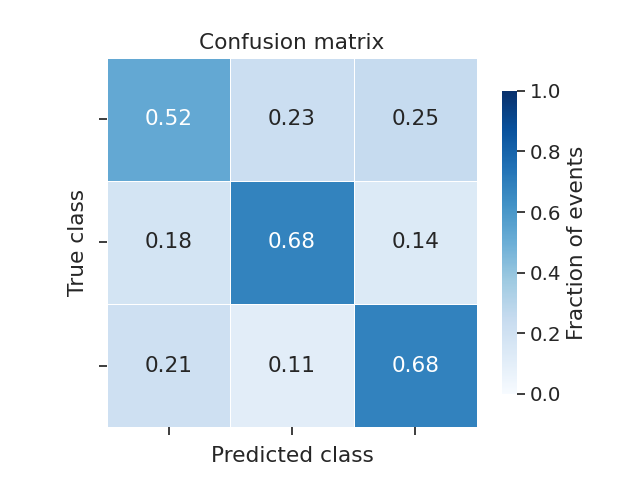

In [83]:
title = 'Confusion matrix'
analysis.plot_confusion_matrix(test_data_labels, y_pred_test, normalise='accuracy', title=title,
                               dict_label_to_real=analysis.dict_label_to_real_plasticc)

ROC Curves

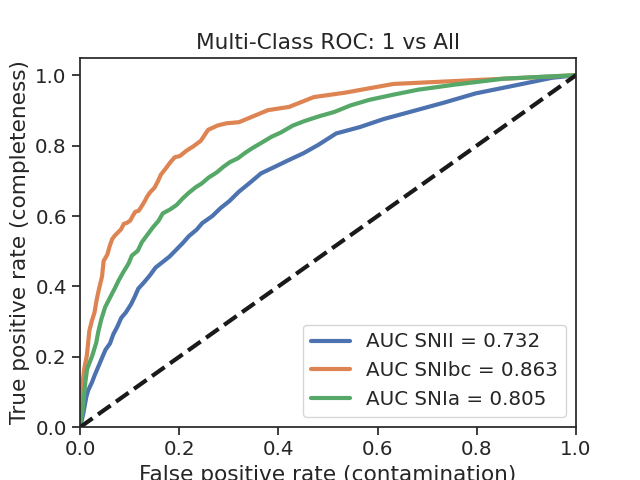

In [84]:
analysis.plot_classifier_roc_curve(test_data_labels, y_probs_test,
                                   dict_label_to_real=analysis.dict_label_to_real_plasticc)

And that's it! An end-to-end analysis to reproduce our results on the PLAsTiCC dataset.

[Go back to top.](#index)